# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

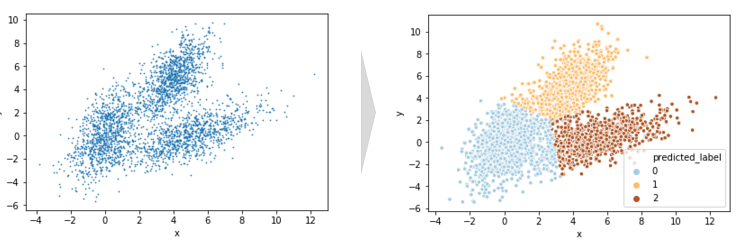

### Introduction

In this lab, we will implement **K-means clustering** on the **Iris dataset**, a widely used dataset containing three types of flowers, each represented by four features. K-means is a popular clustering algorithm that partitions data into $K$ clusters by iteratively assigning points to the nearest centroid and updating cluster centers.

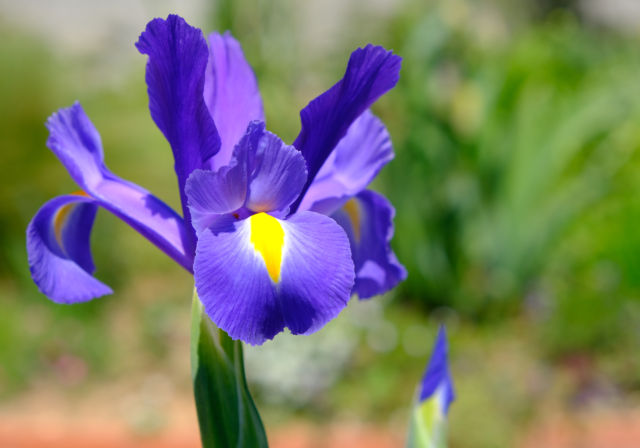

## Import some packages

In [2]:
import numpy as np
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn import datasets

## Load Dataset

Our first step is to load the dataset and explore its structure before applying K-means clustering. The dataset consists of 150 samples, each with four features:
- Sepal Length
- Sepal Width
- Petal Length
- Petal Width

In [3]:
if __name__ == '__main__':
    iris = datasets.load_iris()
    X = iris.data
    feature_names = iris.feature_names  # Get feature names

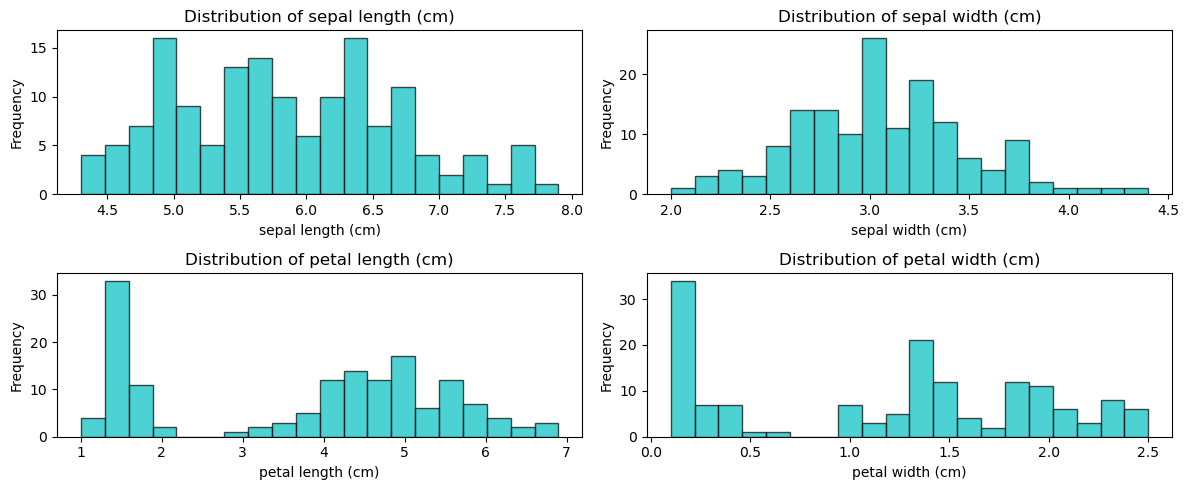

In [4]:
# Visualizing feature distributions
if __name__ == "__main__":
    plt.figure(figsize=(12, 5))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.hist(X[:, i], bins=20, alpha=0.7, color='c', edgecolor='k')
        plt.title(f"Distribution of {feature_names[i]}")
        plt.xlabel(feature_names[i])
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Data Preprocessing
We define a simple data pre-processing function, `preprocess_iris`, that
1. selects data from the Pandas DataFrame and stores it in a NumPy array;
2. scales all the values to be within the range from 0 to 1.

In [31]:
def preprocess_iris(df):
    """ Preprocesses only petal features (more relevant for clustering). """
    X = np.array(df)
    X_mins = X.min(axis=0)
    X_maxs = X.max(axis=0)
    X_scaled = (X - X_mins) / (X_maxs - X_mins)
    
    return X_scaled

if __name__ == "__main__":
    # Apply preprocessing
    X = preprocess_iris(X)
    print(X)

[[0.22222222 0.625      0.06779661 0.04166667]
 [0.16666667 0.41666667 0.06779661 0.04166667]
 [0.11111111 0.5        0.05084746 0.04166667]
 [0.08333333 0.45833333 0.08474576 0.04166667]
 [0.19444444 0.66666667 0.06779661 0.04166667]
 [0.30555556 0.79166667 0.11864407 0.125     ]
 [0.08333333 0.58333333 0.06779661 0.08333333]
 [0.19444444 0.58333333 0.08474576 0.04166667]
 [0.02777778 0.375      0.06779661 0.04166667]
 [0.16666667 0.45833333 0.08474576 0.        ]
 [0.30555556 0.70833333 0.08474576 0.04166667]
 [0.13888889 0.58333333 0.10169492 0.04166667]
 [0.13888889 0.41666667 0.06779661 0.        ]
 [0.         0.41666667 0.01694915 0.        ]
 [0.41666667 0.83333333 0.03389831 0.04166667]
 [0.38888889 1.         0.08474576 0.125     ]
 [0.30555556 0.79166667 0.05084746 0.125     ]
 [0.22222222 0.625      0.06779661 0.08333333]
 [0.38888889 0.75       0.11864407 0.08333333]
 [0.22222222 0.75       0.08474576 0.08333333]
 [0.30555556 0.58333333 0.11864407 0.04166667]
 [0.22222222 

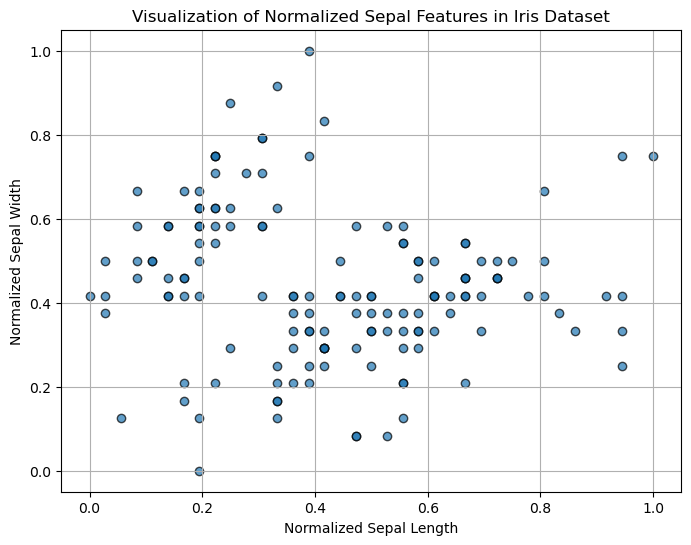

In [19]:
# Visualizing the normalized sepal features
if __name__ == "__main__":
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], alpha=0.7, edgecolors='k')
    plt.xlabel("Normalized Sepal Length")
    plt.ylabel("Normalized Sepal Width")
    plt.title("Visualization of Normalized Sepal Features in Iris Dataset")
    plt.grid(True)
    plt.show()

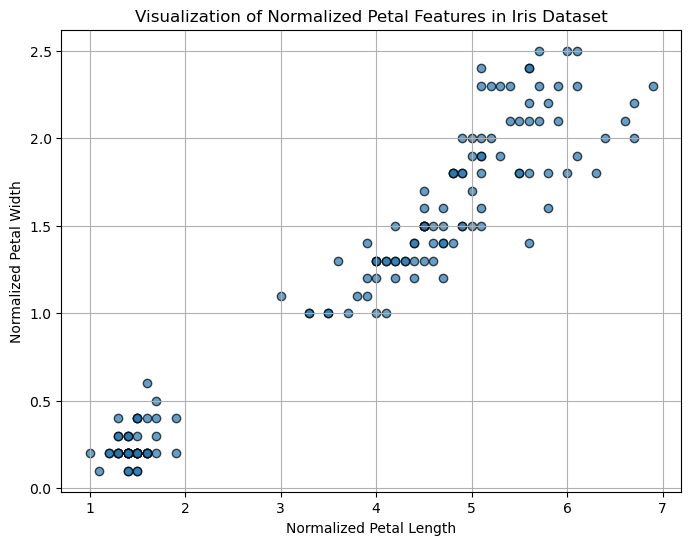

In [5]:
# Visualizing the normalized petal features
if __name__ == "__main__":
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 2], X[:, 3], alpha=0.7, edgecolors='k')
    plt.xlabel("Normalized Petal Length")
    plt.ylabel("Normalized Petal Width")
    plt.title("Visualization of Normalized Petal Features in Iris Dataset")
    plt.grid(True)
    plt.show()

## **K-means++**

### **Background**

#### Importance of Proper Cluster Initialization
The initialization of cluster centers is crucial for the performance of K-means. A poor initialization can lead to:
- **Slow convergence**: The algorithm may take more iterations to stabilize.
- **Suboptimal clustering**: It may get stuck in local minima, resulting in poor clustering results.
- **Unstable results**: Different runs of the algorithm may produce significantly different clusters.

A common issue with K-means is that random initialization can result in unevenly distributed or redundant centroids, leading to poor clustering performance. To improve this, we will use **K-means++** initialization, which selects initial cluster centers in a way that maximizes their spread across the dataset. This method helps:
- Improve stability across different runs. ✅ 
- Speed up convergence. ✅ 
- Reduce the risk of poor clustering outcomes. ✅

### **K-means++ Clustering Steps**
#### K-means++ Initialization
1. Select the first centroid $x_0$ randomly from the dataset, add it to the centroid list.
2. For each remaining $ K - 1 $ centroid:
    - a. Compute the minimal Euclidean distance of each **remaining** data point (except for the points in the centorid list) to the points in the centroids list:
      $$ D(x_i) = \min_{c \in C}{\sqrt{\sum_{j = 1}^d{(x_{ij} - c_j)^2}}} $$
      where:
        - $ C $ is the set of already chosen centroids.
        - $ c_j $ is the $ j $ th feature of the centroid $ c $.
        - $ x_i $ is the $ i $ th data point.
        - $ x_{ij} $ is the $ j $ th feature in the $ i $ th data point.
        - $ d $ is the number of features.
    - b. Assign a probability for each data point to be selected as the next centroid:
      $$ P(x_i) = \frac{D(x_i)^2}{\sum_j{D(x_j)^2}} $$
      where:
        - $ P(x_i) $ is the probability of selecting this data point as a centroid.
        - $ D(x_i) $ is the shortest Euclidean distance from $ x_i $ to the nearest already chosen centroid.
        - $ \sum_j{D(x_j)^2} $ is the normalization factor ensuring probabilities sum to 1.
    - c. Randomly select the next centroid based on probability $P(x_i)$ and add it to the centroid list.
3. Repeat until $K$ centroids are chosen.

#### Iteration Steps
- Assign Data Points
  - Calculate the distance from each data point to all cluster centroids.
  - Assign each data point to the nearest cluster centroid.
- Compute New Centroids
  - Update the position of each cluster centroid based on the current assignments.

#### Convergence Check
- Stop the algorithm based on the maximum number of iterations or other specified criteria.

## **Tasks**

### **Task 1: K-means++ Initialization**
Select $K$ cluster centroids using the K-means++ algorithm, ensuring they are well spread to improve convergence and clustering quality.

- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point and each column represents a feature.
    - $K$: The number of clusters, determining how many initial centroids need to be selected.

- Output:
    - A NumPy array of shape $(K,d)$, where $K$ is the number of clusters and $d$ is the number of features. Each row represents a selected initial centroid.

- Steps:
    1. Directly select the **first** point in the dataset, and add it the centroids list. (For simplification, we do not use a random initialization)
    2. Compute the distance of the **remaining** points (except for the points in the centroids list) to its nearest centroid.
    3. Select the point that has the **largest distance** to its nearest centroid. If more than one point have been selected, just choose the first one. (For simplification, we do not random select the centroids based on probability)
    4. Repeat the process until $K$ centroids are chosen.
    
- Remark:
    - Please use vectorization instead of loops to complete *TODO*.

In [6]:
def initialize_centroids_kmeans_pp(X, K):
    """
    Initializes K cluster centroids using a simplified max-min method.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        K (int): Number of clusters.

    Returns:
        centroids (ndarray): Initialized centroids of shape (K, n_features).
    """    
    # Step 1: Select the first centroid
    centroids = [X[0]]
    
    for _ in range(1, K):
        # Step 2: Compute distance of each point to the nearest centroid
        distances = np.min(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)

        # Step 3: Choose the point with the max distance as the new centroid
        new_centroid = X[np.argmax(distances)]
        centroids.append(new_centroid)
    
    return np.array(centroids)

if __name__ == "__main__":     
    centroids = initialize_centroids_kmeans_pp(X, K=3)
    print(centroids)

[[5.1 3.5 1.4 0.2]
 [7.7 2.6 6.9 2.3]
 [4.9 2.5 4.5 1.7]]


### Task 2: Assign Data Points to Clusters
Compute the Euclidean distance from each data point to all centroids and assign it to the nearest centroid.
- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point.
    - **centroids**: A NumPy array of shape $(k,d)$ containing the current cluster centroids.

- Output:
    - A one-dimensional NumPy array of length $n$, where $n$ is the number of data points. Each value represents the cluster index of the corresponding data point.

- Steps:
    1. Compute the Euclidean distance from each point to all centroids. 
    2. Assign each point to the closest centroid. If the closest centroids are more than one, just select the first one.

- Remark:
    - Please use vectorization instead of loops to complete *TODO*.

In [ ]:
def assign_clusters(X, centroids):
    """
    Assigns each data point to the nearest centroid.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        centroids (ndarray): Current centroids of shape (K, n_features).

    Returns:
        labels (ndarray): Cluster assignments for each data point.
    """
    # TODO: Compute the distance of each point to all centroids
    distances = np.linalg.norm(X - centroids, axis=2)

    # TODO: Assign each point to the closest centroid
    labels = np.argmin(distances, axis=1)

    return labels

if __name__ == "__main__":
    labels = assign_clusters(X, centroids)
    print(labels)

[[[ 0.   0.   0.   0. ]
  [-2.6  0.9 -5.5 -2.1]
  [ 0.2  1.  -3.1 -1.5]]

 [[-0.2 -0.5  0.   0. ]
  [-2.8  0.4 -5.5 -2.1]
  [ 0.   0.5 -3.1 -1.5]]

 [[-0.4 -0.3 -0.1  0. ]
  [-3.   0.6 -5.6 -2.1]
  [-0.2  0.7 -3.2 -1.5]]

 ...

 [[ 1.4 -0.5  3.8  1.8]
  [-1.2  0.4 -1.7 -0.3]
  [ 1.6  0.5  0.7  0.3]]

 [[ 1.1 -0.1  4.   2.1]
  [-1.5  0.8 -1.5  0. ]
  [ 1.3  0.9  0.9  0.6]]

 [[ 0.8 -0.5  3.7  1.6]
  [-1.8  0.4 -1.8 -0.5]
  [ 1.   0.5  0.6  0.1]]]


ValueError: operands could not be broadcast together with shapes (150,4) (3,4) 

### Task 3: Compute the New Centroids
Recalculate the cluster centroids based on the mean position of all data points assigned to each cluster.

- Input:
    - $X$: Input data, a two-dimensional NumPy array where each row represents a data point.
    - **labels**: A one-dimensional array indicating the cluster index of each data point.
    - $K$: The number of clusters.

- Output:
    - A NumPy array of shape $(K,d)$, where $K$ is the number of clusters and $d$ is the number of features. Each row represents the updated cluster centroid.

- Steps:
  1. For each cluster, compute the mean of all assigned data points.
  2. Update the cluster centroids accordingly.

- Remark:
    - You can only use one loop to complete the *TODO*.

In [24]:
def update_centroids(X, labels, K):
    """
    Updates cluster centroids based on the mean of assigned points.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        labels (ndarray): Cluster assignments for each data point.
        K (int): Number of clusters.

    Returns:
        new_centroids (ndarray): Updated centroids of shape (K, n_features).
    """
    # TODO: Compute new centroids as the mean of assigned data points
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(K)])

    return new_centroids

if __name__ == "__main__":
    new_centroids = update_centroids(X, labels, 3)
    print(new_centroids)

[[0.19611111 0.595      0.07830508 0.06083333]
 [0.72698413 0.46071429 0.80338983 0.8297619 ]
 [0.44700855 0.31089744 0.58591917 0.56346154]]


### Task 4: Complete K-Means Implementation

In [25]:
def k_means(X, K, max_iters=100, tol=1e-4):
    """
    Runs the K-means clustering algorithm.

    Parameters:
        X (ndarray): Dataset of shape (n_samples, n_features).
        K (int): Number of clusters.
        max_iters (int): Maximum iterations.
        tol (float): Convergence tolerance.

    Returns:
        final_centroids (ndarray): Final cluster centroids.
        final_labels (ndarray): Final cluster assignments.
    """
    # Step 1: Initialize centroids using K-means++
    centroids = initialize_centroids_kmeans_pp(X, K)

    for _ in range(max_iters):
        # Step 2: Assign points to clusters
        labels = assign_clusters(X, centroids)

        # Step 3: Compute new centroids
        new_centroids = update_centroids(X, labels, K)

        # Step 4: Check for convergence (centroids do not change significantly)
        if np.linalg.norm(centroids - new_centroids) < tol:
            break
        
        centroids = new_centroids

    return centroids, labels

In [26]:
if __name__ == "__main__":
    K = 3 # Number of clusters
    final_centroids, final_labels = k_means(X, K)
    print(final_labels)
    for i in final_labels:
        print(i, end=', ')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 

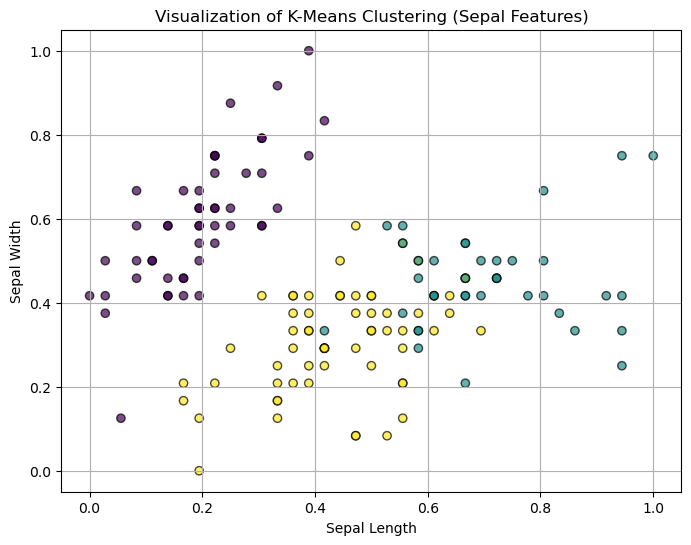

In [27]:
# Visualization of your results
if __name__ == "__main__":
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.xlabel("Sepal Length")
    plt.ylabel("Sepal Width")
    plt.title("Visualization of K-Means Clustering (Sepal Features)")
    # plt.legend()
    plt.grid(True)
    plt.show()

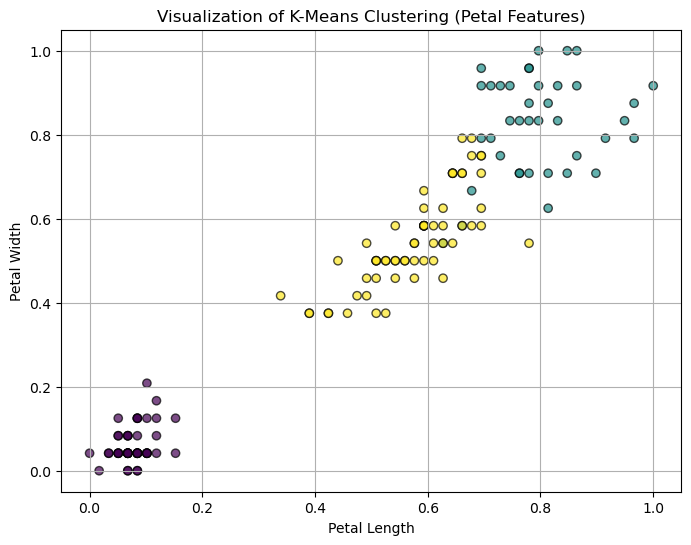

In [28]:
# Visualization of your results
if __name__ == "__main__":
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 2], X[:, 3], c=final_labels, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.xlabel("Petal Length")
    plt.ylabel("Petal Width")
    plt.title("Visualization of K-Means Clustering (Petal Features)")
    # plt.legend()
    plt.grid(True)
    plt.show()